# Proyecto Final: Estimación de Pecios de Alquier en el AMBA

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

from src.preprocesing import mapeo, merge_barrios
from src.knn_barrios import barrios_asigning

Comenzamos cargando nuestro dataset de development y realizándole el preprocesamiento correspondiene

In [3]:
archivo_csv = './data/alquiler_AMBA_dev.csv'
data = pd.read_csv(archivo_csv, low_memory=False)

In [4]:
procesed_data = mapeo(data) #data preprocesada
no_repeated_barrios = merge_barrios(procesed_data) #asignamos todos los sub-barrios al barrio madre 
handle_missing_barrios = barrios_asigning(no_repeated_barrios) #los barrios no definidos se reemplazan por sus predicciones y los barrios con menos de 150 propiedades se los asigna al barrio grande más cercano

## Relaciones entre features

Una vez preprocesado, pasamos a graficar relaciones, features y distribuciones que nos puedan ayudar a entender mejor los datos

/var/folders/p2/ch6_kmpn1g73c88qsyfcn2_00000gr/T/ipykernel_8737/4270511838.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap('tab10', len(procesed_barrios_CABA['ITE_ADD_NEIGHBORHOOD_NAME'].unique()))  # Colormap con colores únicos


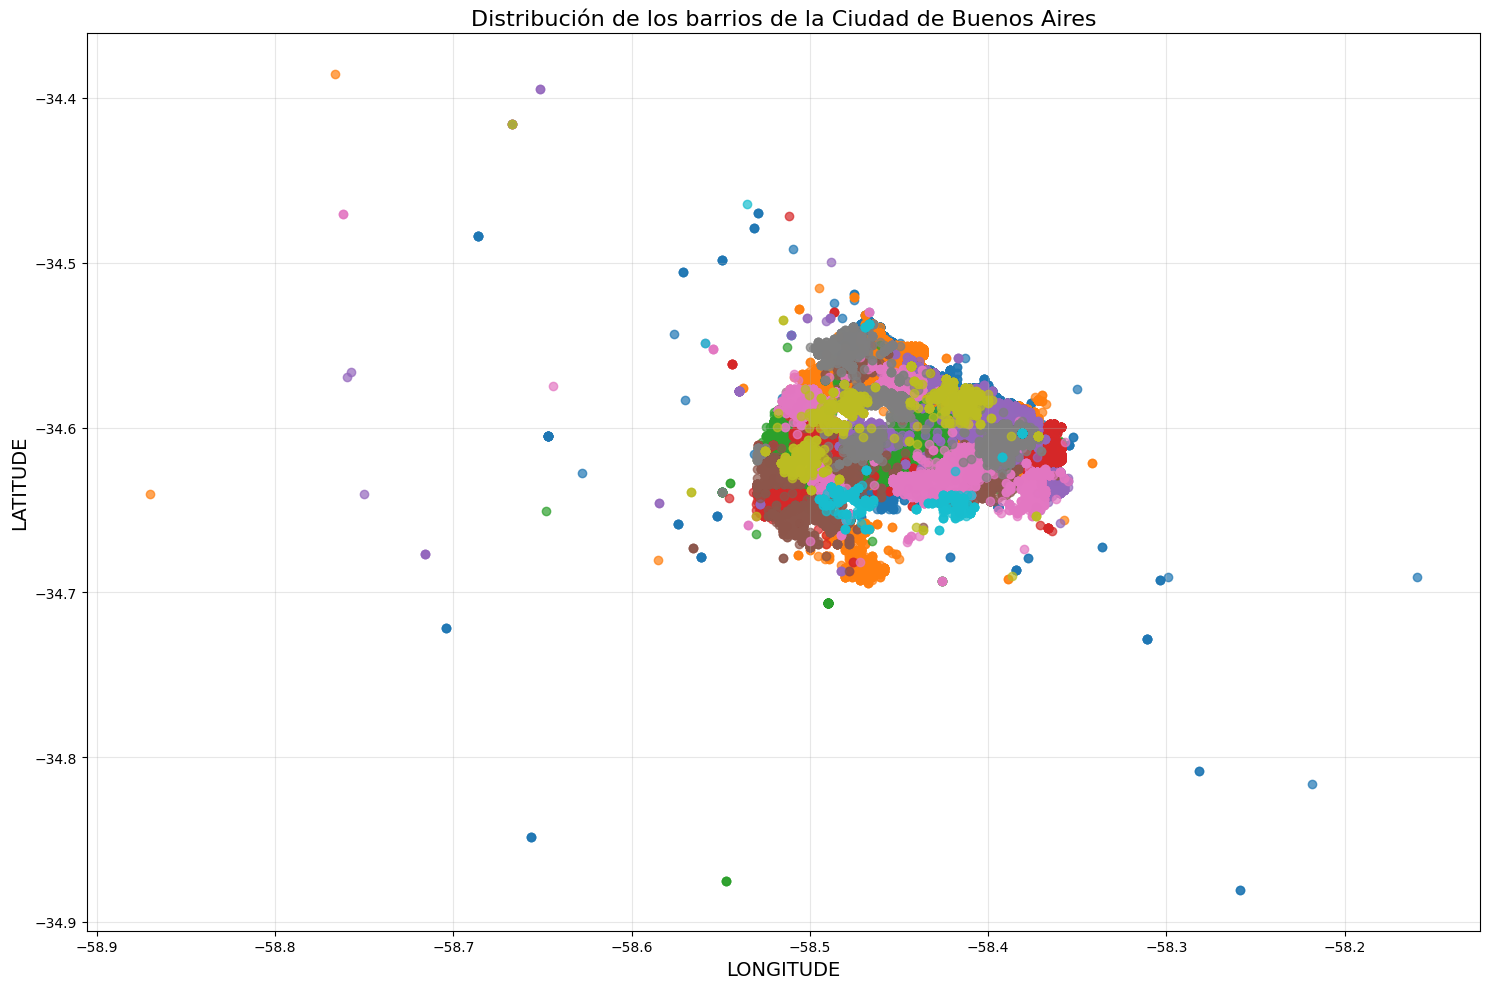

In [ ]:
procesed_barrios_CABA = handle_missing_barrios[handle_missing_barrios['ITE_ADD_STATE_NAME'] == 0.0]

plt.figure(figsize=(15, 10))
colores = plt.cm.get_cmap('tab10', len(procesed_barrios_CABA['ITE_ADD_NEIGHBORHOOD_NAME'].unique()))
unique_barrios = procesed_barrios_CABA['ITE_ADD_NEIGHBORHOOD_NAME'].unique()
color_map = {barrio: colores(i) for i, barrio in enumerate(unique_barrios)}
for barrio in unique_barrios:
    subset = procesed_barrios_CABA[procesed_barrios_CABA['ITE_ADD_NEIGHBORHOOD_NAME'] == barrio]
    plt.scatter(subset['LONGITUDE'], subset['LATITUDE'], 
                label=barrio, color=color_map[barrio], alpha=0.7)
plt.title('Distribución de los barrios de la Ciudad de Buenos Aires', fontsize=16)
plt.xlabel('LONGITUDE', fontsize=14)
plt.ylabel('LATITUDE', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

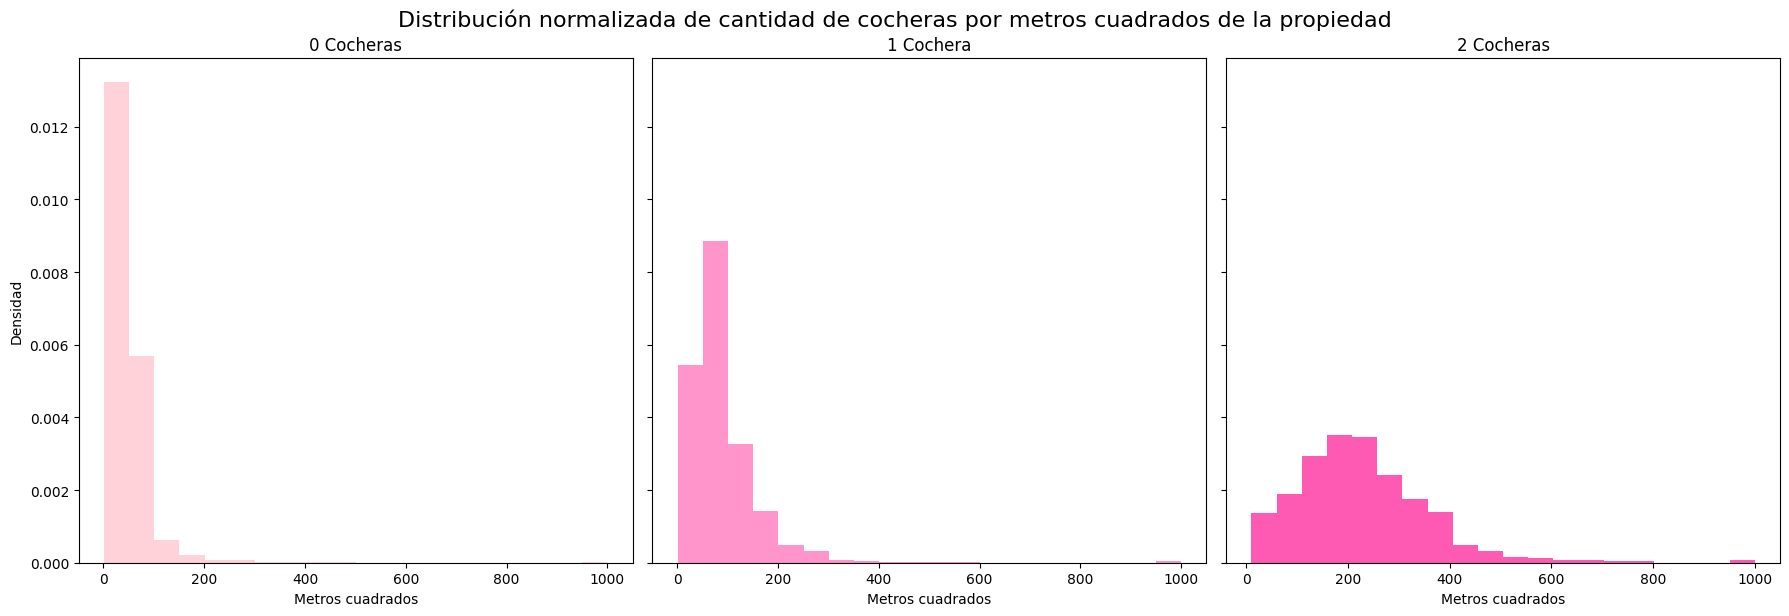

In [90]:
cocheras_0 = handle_missing_barrios[handle_missing_barrios['Cocheras'] == 0]
cocheras_1 = handle_missing_barrios[handle_missing_barrios['Cocheras'] == 1]
cocheras_2 = handle_missing_barrios[handle_missing_barrios['Cocheras'] == 2]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True) 

axs[0].hist(cocheras_0['STotalM2'], bins=20, color='pink', alpha=0.7, density=True)
axs[0].set_title("0 Cocheras")
axs[0].set_xlabel("Metros cuadrados")
axs[0].set_ylabel("Densidad")

axs[1].hist(cocheras_1['STotalM2'], bins=20, color='hotpink', alpha=0.7, density=True)
axs[1].set_title("1 Cochera")
axs[1].set_xlabel("Metros cuadrados")

axs[2].hist(cocheras_2['STotalM2'], bins=20, color='deeppink', alpha=0.7, density=True)
axs[2].set_title("2 Cocheras")
axs[2].set_xlabel("Metros cuadrados")

plt.tight_layout()
plt.suptitle("Distribución normalizada de cantidad de cocheras por metros cuadrados de la propiedad", y=1.02, fontsize=16)
plt.show()


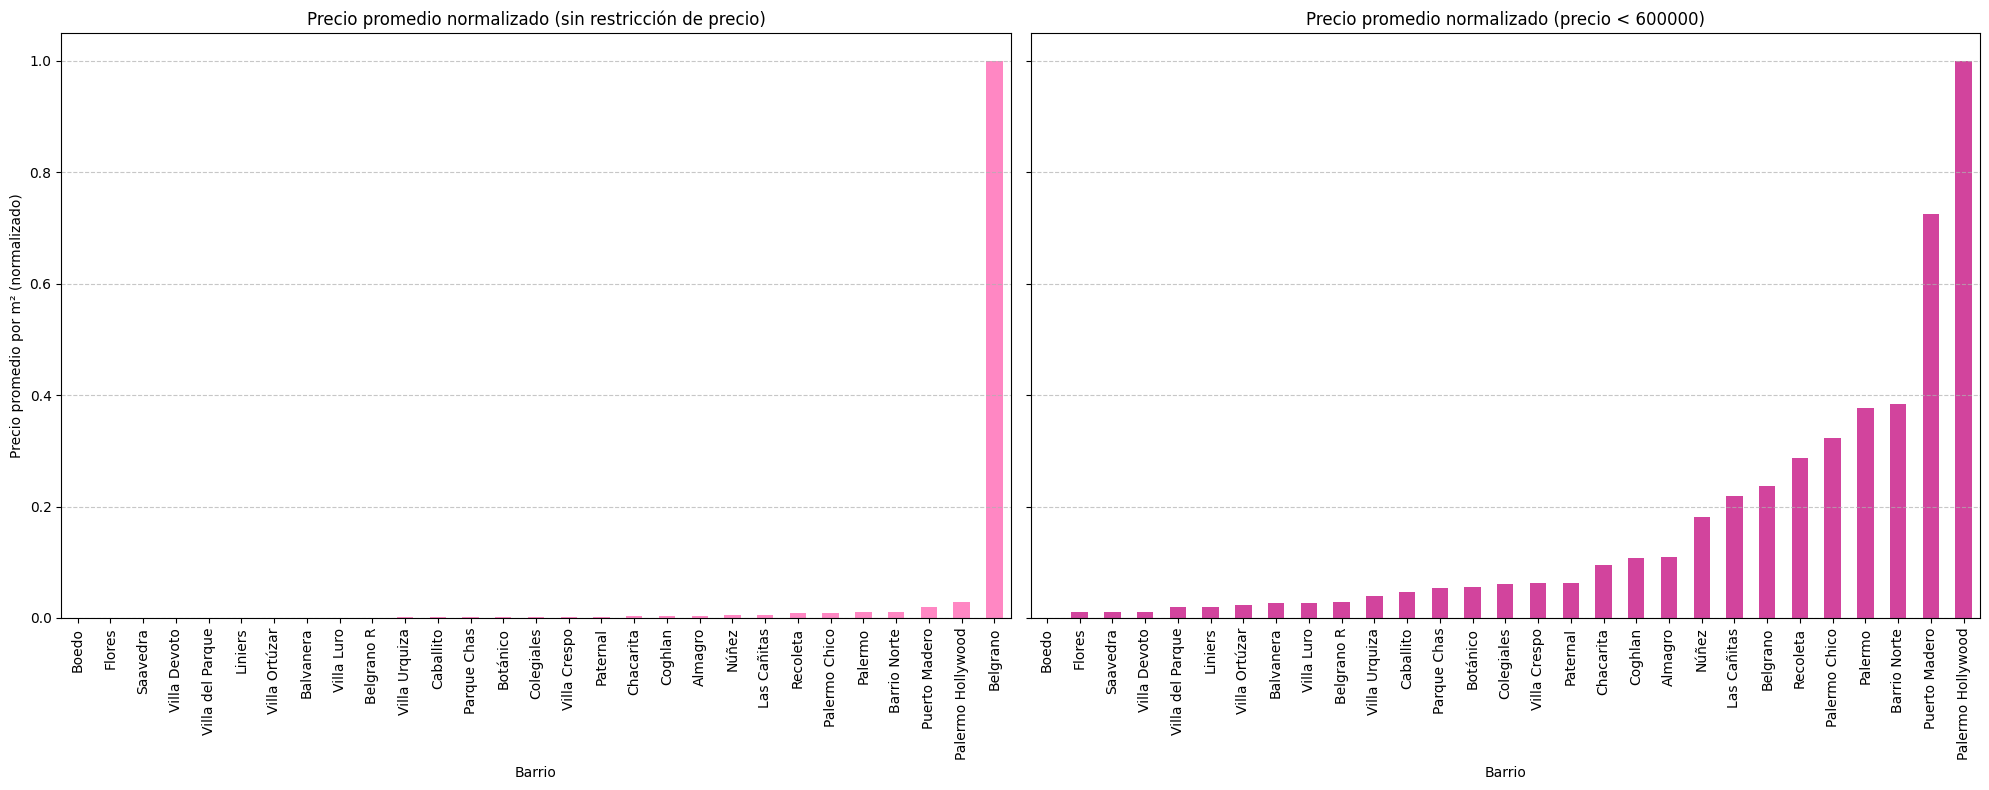

In [ ]:
# se evalúa un prototipo de propiedad  
filtro_1 = (
    (data['Ambientes'] == 2) &
    (data['STotalM2'] >= 75) & (data['STotalM2'] <= 85) &
    (data['Cocheras'] == 1) &
    (data['Banos'] == 1)
)

data_filtrado_1 = data[filtro_1].copy()
ciudad_especifica = "Capital Federal"
data_CABA_1 = data_filtrado_1[data_filtrado_1['ITE_ADD_CITY_NAME'] == ciudad_especifica].copy()
data_CABA_1['precio_por_m2'] = data_CABA_1['precio_pesos_constantes'] / data_CABA_1['STotalM2']
precio_promedio_por_barrio_1 = data_CABA_1.groupby('ITE_ADD_NEIGHBORHOOD_NAME')['precio_por_m2'].mean().sort_values()

# Segundo filtro (es decir sin los outliers)
filtro_2 = (
    (data['Ambientes'] == 2) &
    (data['STotalM2'] >= 75) & (data['STotalM2'] <= 85) &
    (data['Cocheras'] == 1) &
    (data['Banos'] == 1) &
    (data['precio_pesos_constantes'] < 600000)
)

data_filtrado_2 = data[filtro_2].copy()
data_CABA_2 = data_filtrado_2[data_filtrado_2['ITE_ADD_CITY_NAME'] == ciudad_especifica].copy()
data_CABA_2['precio_por_m2'] = data_CABA_2['precio_pesos_constantes'] / data_CABA_2['STotalM2']
precio_promedio_por_barrio_2 = data_CABA_2.groupby('ITE_ADD_NEIGHBORHOOD_NAME')['precio_por_m2'].mean().sort_values()

scaler = MinMaxScaler()
precio_promedio_por_barrio_1_norm = pd.Series(
    scaler.fit_transform(precio_promedio_por_barrio_1.values.reshape(-1, 1)).flatten(),
    index=precio_promedio_por_barrio_1.index
)
precio_promedio_por_barrio_2_norm = pd.Series(
    scaler.fit_transform(precio_promedio_por_barrio_2.values.reshape(-1, 1)).flatten(),
    index=precio_promedio_por_barrio_2.index
)

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

precio_promedio_por_barrio_1_norm.plot(kind='bar', color='hotpink', alpha=0.8, ax=axes[0])
axes[0].set_title("Precio promedio normalizado (sin restricción de precio)")
axes[0].set_xlabel("Barrio")
axes[0].set_ylabel("Precio promedio por m² (normalizado)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
precio_promedio_por_barrio_2_norm.plot(kind='bar', color='mediumvioletred', alpha=0.8, ax=axes[1])
axes[1].set_title("Precio promedio normalizado (precio < 600000)")
axes[1].set_xlabel("Barrio")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, fontsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



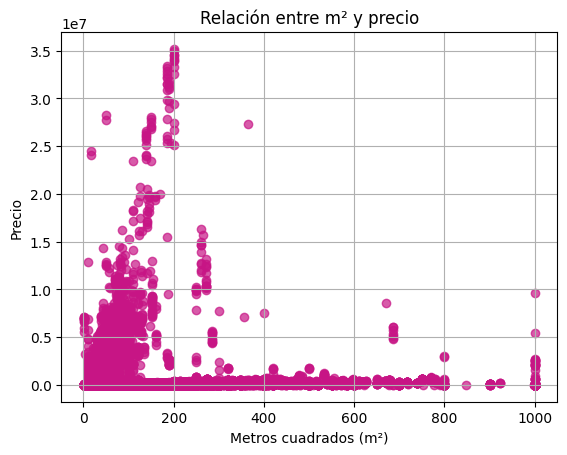

In [97]:
plt.scatter(handle_missing_barrios['STotalM2'], handle_missing_barrios['precio_pesos_constantes'], alpha=0.7, color='mediumvioletred')
plt.title("Relación entre m² y precio")
plt.xlabel("Metros cuadrados (m²)")
plt.ylabel("Precio")
plt.grid(True)
plt.show()

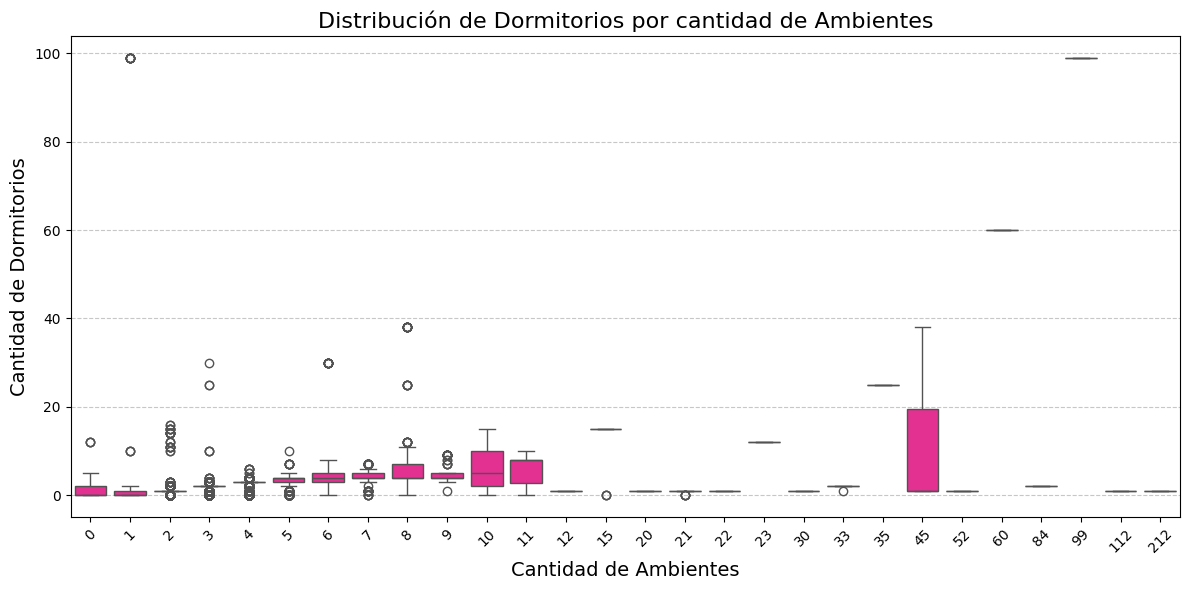

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Ambientes', y='Dormitorios', data=data, showfliers=True, color='deeppink')
plt.title("Distribución de Dormitorios por cantidad de Ambientes", fontsize=16)
plt.xlabel("Cantidad de Ambientes", fontsize=14)
plt.ylabel("Cantidad de Dormitorios", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


Analizamos cómo cambia este feature, después de preprocesar los datos y eliminar las filas con datos erróneos

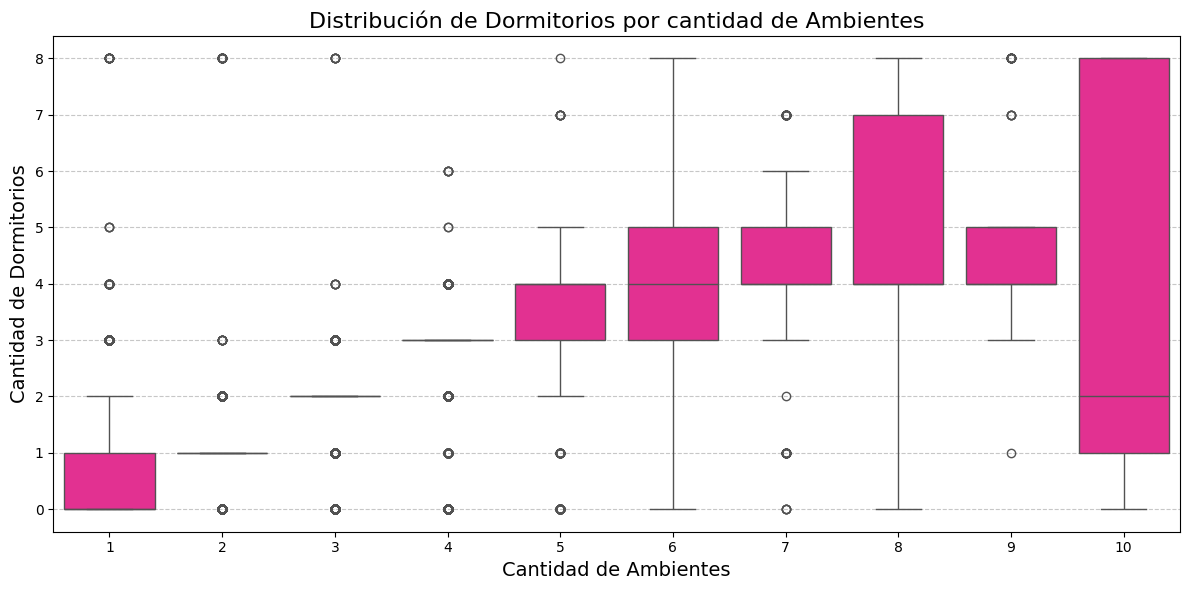

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Ambientes', y='Dormitorios', data=handle_missing_barrios, showfliers=True, color='deeppink')
plt.title("Distribución de Dormitorios por cantidad de Ambientes", fontsize=16)
plt.xlabel("Cantidad de Ambientes", fontsize=14)
plt.ylabel("Cantidad de Dormitorios", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

---
# Predicciones

Para hacer un encoding más óptimo de la columna Neighbourhood, se realizo una clusterización y ranking por zonas más caras.

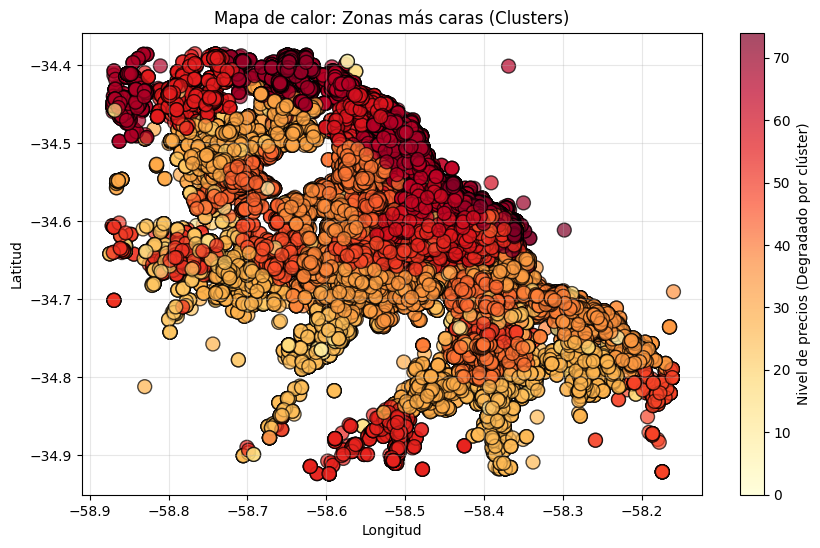

   LONGITUDE   LATITUDE  precio_m2  cluster  cluster_ordenado
0 -58.566145 -34.599299   0.006211       13                37
1 -58.473708 -34.551759   0.004303       53                64
2 -58.385136 -34.599685   0.011830       73                45
3 -58.393617 -34.585162   0.003545       11                70
4 -58.376592 -34.610603   0.000039       42                74


In [5]:
total_data = handle_missing_barrios

data_zonas = total_data[['LONGITUDE', 'LATITUDE']].copy()
data_zonas['precio_m2'] = total_data['STotalM2'] / total_data['precio_pesos_constantes']

scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_zonas[['LONGITUDE', 'LATITUDE', 'precio_m2']])
n_clusters = 75 

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_zonas['cluster'] = kmeans.fit_predict(df_scaled)

cluster_precio = data_zonas.groupby('cluster')['precio_m2'].mean().sort_values(ascending=False)
cluster_mapping = {cluster: idx for idx, cluster in enumerate(cluster_precio.index)}
data_zonas['cluster_ordenado'] = data_zonas['cluster'].map(cluster_mapping)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    data_zonas['LONGITUDE'],
    data_zonas['LATITUDE'],
    c=data_zonas['cluster_ordenado'],  
    cmap='YlOrRd',  
    s=100,  
    edgecolor='k',
    alpha=0.7
)
cbar = plt.colorbar(scatter)
cbar.set_label('Nivel de precios (Degradado por clúster)')
plt.title('Mapa de calor: Zonas más caras (Clusters)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(alpha=0.3)
plt.show()
print(data_zonas.head())

total_data['ITE_ADD_NEIGHBORHOOD_NAME'] = data_zonas['cluster_ordenado'].values
total_data.to_csv('./data/datos_listos_para_el_modelo.csv', index=False)



Luego de esto se paso a analizar la matriz de correlación en función al precio de los alquileres, de esta manera se detectaron los datos que tenían precios poco coherentes/erróneos que sesgaban el modelo.

In [7]:
#matriz de correlación antes de filtrar los datos espurios
data_final = pd.read_csv('./data/datos_listos_para_el_modelo.csv')
correlation_matrix = data_final.corr()
correlation_with_price = correlation_matrix['precio_pesos_constantes']
print(correlation_with_price)

id_grid                     -0.001749
STotalM2                     0.057143
SConstrM2                    0.054845
Dormitorios                  0.056455
Banos                        0.065444
Ambientes                    0.058009
Amoblado                    -0.007091
Antiguedad                  -0.009221
AccesoInternet               0.021016
Gimnasio                     0.025318
Laundry                      0.002125
Calefaccion                  0.034214
SalonDeUsosMul               0.017060
AireAC                       0.016950
Recepcion                    0.018674
Estacionamiento              0.009510
Ascensor                     0.031457
Seguridad                    0.029984
Pileta                       0.018173
Cocheras                     0.055440
AreaParrillas                0.007836
CanchaTennis                 0.004359
ITE_ADD_CITY_NAME           -0.002636
ITE_ADD_STATE_NAME          -0.009988
ITE_ADD_NEIGHBORHOOD_NAME    0.063316
ITE_TIPO_PROD               -0.002636
LONGITUDE   

Se puede observar como ningún feature influye significativamente en el precio, esto da un indicio de que hay valores que estan sezgando el modelo y evitando que se puedan apreciar las correlaciones.

In [8]:
#aca se filtran los datos con precios extraorbitarios
archivo_csv = './data/datos_listos_para_el_modelo.csv'
data_final = pd.read_csv(archivo_csv, low_memory=False)

data_filtered = data_final[data_final['precio_pesos_constantes'] <= 600000]
output_file = './data/datos_filtrados.csv'
data_filtered.to_csv(output_file, index=False)

print(f"Datos filtrados guardados en: {output_file}")

Datos filtrados guardados en: ./data/datos_filtrados.csv


Se vuelve analizar la correlación una vez eliminados los datos espurios

In [9]:
data_final = pd.read_csv('./data/datos_filtrados.csv')
correlation_matrix = data_final.corr()
correlation_with_price = correlation_matrix['precio_pesos_constantes']
print(correlation_with_price)

id_grid                      0.150684
STotalM2                     0.635557
SConstrM2                    0.686775
Dormitorios                  0.516650
Banos                        0.700729
Ambientes                    0.542294
Amoblado                     0.167260
Antiguedad                   0.019556
AccesoInternet               0.217863
Gimnasio                     0.411663
Laundry                      0.272365
Calefaccion                  0.179240
SalonDeUsosMul               0.316876
AireAC                       0.227495
Recepcion                    0.033675
Estacionamiento              0.054800
Ascensor                    -0.029137
Seguridad                    0.289381
Pileta                       0.358921
Cocheras                     0.561207
AreaParrillas                0.071582
CanchaTennis                 0.099935
ITE_ADD_CITY_NAME           -0.090011
ITE_ADD_STATE_NAME          -0.214021
ITE_ADD_NEIGHBORHOOD_NAME    0.437523
ITE_TIPO_PROD               -0.090011
LONGITUDE   

A su vez, para asegurarnos de estar realizando una buena cota superior del precio máximo de alquiler que ibámos a permitir en el modelo, se graficaron las distibuciones de los precios antes y después de realizar el filtrado de valores de alquiler.

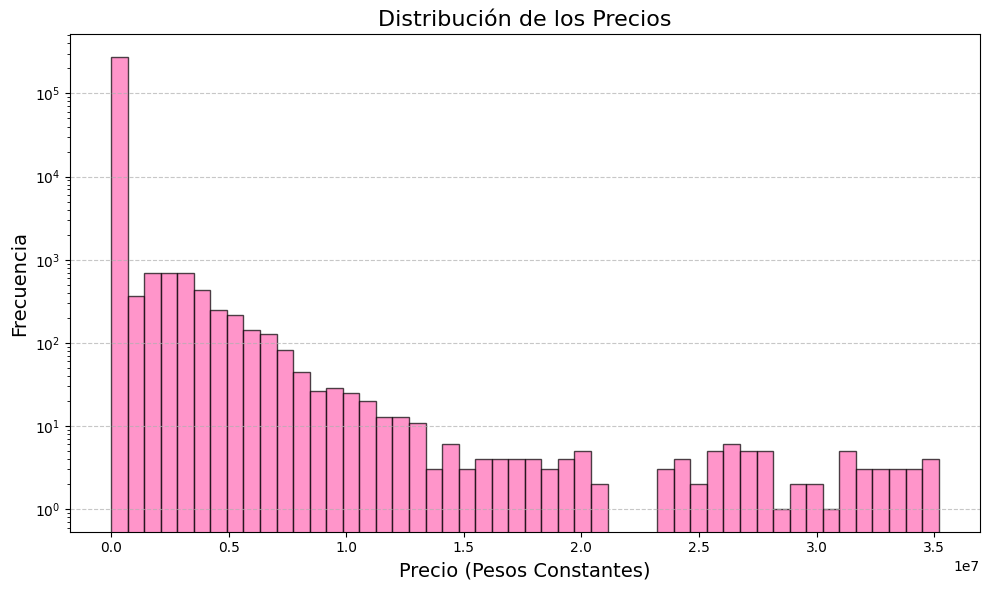

In [14]:

archivo_csv = './data/datos_listos_para_el_modelo.csv'
data_final = pd.read_csv(archivo_csv, low_memory=False)
precios = data_final['precio_pesos_constantes']

plt.figure(figsize=(10, 6))
plt.hist(precios, bins=50, color='hotpink', edgecolor='black', alpha=0.7, log=True)
plt.title("Distribución de los Precios", fontsize=16)
plt.xlabel("Precio (Pesos Constantes)", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

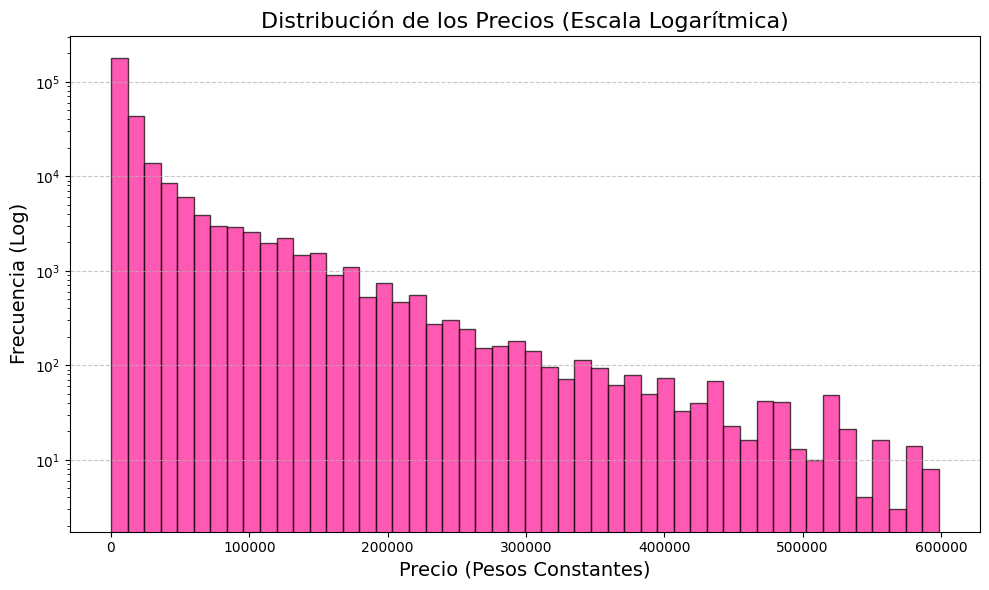

In [15]:
archivo_csv = './data/datos_filtrados.csv'
datos_filtrados = pd.read_csv(archivo_csv, low_memory=False)
precios = datos_filtrados['precio_pesos_constantes']

plt.figure(figsize=(10, 6))
plt.hist(precios, bins=50, color='deeppink', edgecolor='black', alpha=0.7, log=True)  
plt.title("Distribución de los Precios (Escala Logarítmica)", fontsize=16)
plt.xlabel("Precio (Pesos Constantes)", fontsize=14)
plt.ylabel("Frecuencia (Log)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Modelo de Regresión

Con los datos ya filtrados apropiadamente se paso a implementar como primera instancia un modelo de regresión polinómica, aplicando un polinomio de grado 2.

Error cuadrático medio (MSE) en entrenamiento: 359370797.4578
RMSE en entrenamiento: 18957.0778
MAE en entrenamiento: 8094.6098
R^2 en entrenamiento: 0.8178

Error cuadrático medio (MSE) en prueba: 344670555.8618
RMSE en prueba: 18565.3052
MAE en prueba: 8068.5625
R^2 en prueba: 0.8215


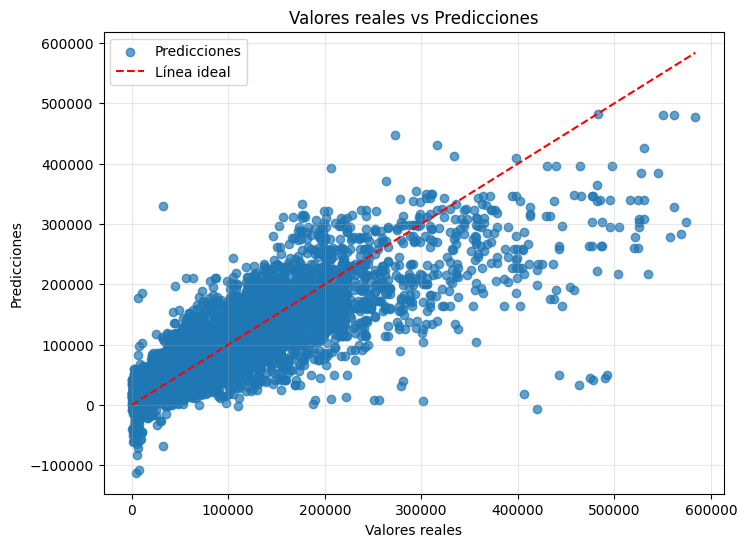

In [16]:
archivo_csv = './data/datos_filtrados.csv'
data_filtrada = pd.read_csv(archivo_csv, low_memory=False) 

X = data_filtrada.iloc[:, :-1]  
y = data_filtrada.iloc[:, -1]


X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

degree = 2 
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_reg)
X_test_poly = poly_features.transform(X_test_reg)

regression_model = LinearRegression()
regression_model.fit(X_train_poly, Y_train_reg)

Y_train_pred = regression_model.predict(X_train_poly)
Y_test_pred = regression_model.predict(X_test_poly)

train_mse = mean_squared_error(Y_train_reg, Y_train_pred)
test_mse = mean_squared_error(Y_test_reg, Y_test_pred)
train_mae = mean_absolute_error(Y_train_reg, Y_train_pred)
test_mae = mean_absolute_error(Y_test_reg, Y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(Y_train_reg, Y_train_pred)
test_r2 = r2_score(Y_test_reg, Y_test_pred)

print(f"Error cuadrático medio (MSE) en entrenamiento: {train_mse:.4f}")
print(f"RMSE en entrenamiento: {train_rmse:.4f}")
print(f"MAE en entrenamiento: {train_mae:.4f}")
print(f"R^2 en entrenamiento: {train_r2:.4f}\n")

print(f"Error cuadrático medio (MSE) en prueba: {test_mse:.4f}")
print(f"RMSE en prueba: {test_rmse:.4f}")
print(f"MAE en prueba: {test_mae:.4f}")
print(f"R^2 en prueba: {test_r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(Y_test_reg, Y_test_pred, alpha=0.7, label='Predicciones')
plt.plot([Y_test_reg.min(), Y_test_reg.max()], [Y_test_reg.min(), Y_test_reg.max()], '--r', label='Línea ideal')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


El gráfico de dispersión muestra una correlación positiva entre los valores reales y las predicciones, con una mayoría de puntos cercanos a la línea ideal, dando un buen desempeño general del modelo. Sin embargo, hay algunos puntos alejados de la línea, estos muestran errores para la predicción en ciertos casos. La razón de esto pueden ser outliers o a limitaciones del modelo para capturar relaciones más complejas en los datos.  
Decidimos entonces implementar un modelo de MLP, para ver si este podía capturar mejor las relaciones entre los datos y dar mejores resultados.

## Modelo MLP

Buscando mejorar los resultados obtenidos, se entreno una red neuronal (MLP)

Epoch 1/100


c:\Users\manue\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3434/3434 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 843166208.0000 - mae: 12167.3438 - mse: 843166208.0000 - val_loss: 410858176.0000 - val_mae: 8074.1279 - val_mse: 410858176.0000
Epoch 2/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 429258080.0000 - mae: 7923.6060 - mse: 429258080.0000 - val_loss: 372533376.0000 - val_mae: 7334.7798 - val_mse: 372533376.0000
Epoch 3/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 386637728.0000 - mae: 7463.8940 - mse: 386637728.0000 - val_loss: 354101728.0000 - val_mae: 7275.4468 - val_mse: 354101728.0000
Epoch 4/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 375140704.0000 - mae: 7254.6914 - mse: 375140704.0000 - val_loss: 345883040.0000 - val_mae: 7097.2983 - val_mse: 345883040.0000
Epoch 5/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 356333920.0000 - mae: 7051.3359 - mse: 356333920.0000 - val_loss: 342133312.0000 - val_mae: 7121.7202 - val_mse: 342133312.0000
Epoch 6/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/

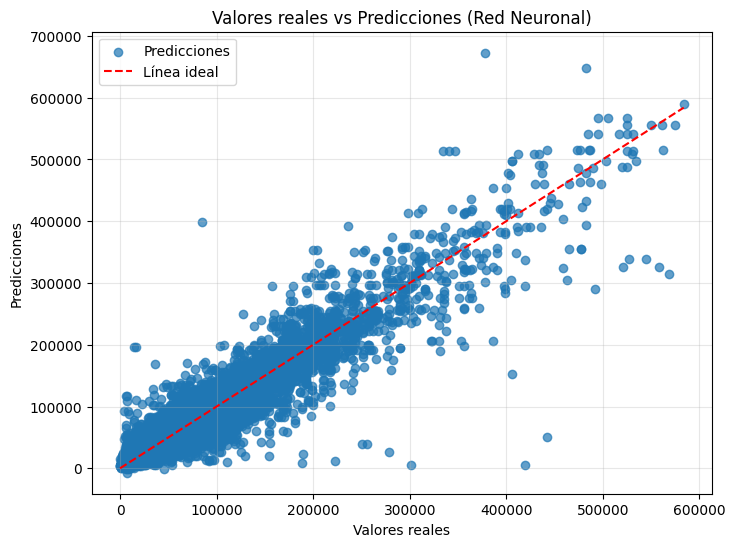

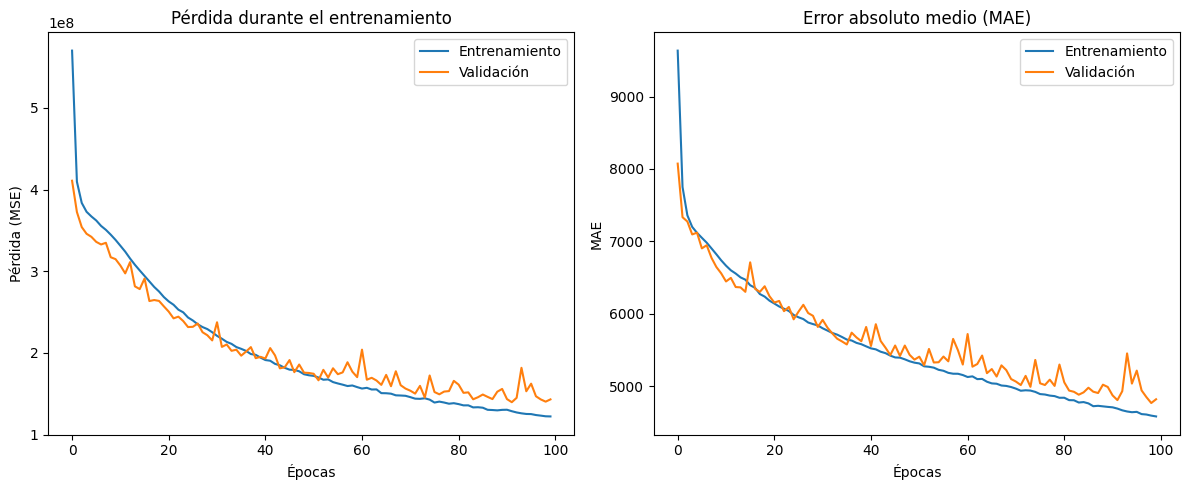

In [20]:
archivo_csv = './data/datos_filtrados.csv'
data_filtrada = pd.read_csv(archivo_csv, low_memory=False)

X = data_filtrada.iloc[:, :-1]  
y = data_filtrada.iloc[:, -1]

X_train_mlp, X_test_mlp, Y_train_mlp, Y_test_mlp = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_mlp)
X_test_scaled = scaler.transform(X_test_mlp)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

history = model.fit(
    X_train_scaled, Y_train_mlp,
    validation_data=(X_test_scaled, Y_test_mlp),
    epochs=100,  
    batch_size=64,
    verbose=1
)

train_loss, train_mae, train_mse = model.evaluate(X_train_scaled, Y_train_mlp, verbose=0)
test_loss, test_mae, test_mse = model.evaluate(X_test_scaled, Y_test_mlp, verbose=0)

Y_test_pred_nn = model.predict(X_test_scaled).flatten()

train_r2_nn = r2_score(Y_train_mlp, model.predict(X_train_scaled).flatten())
test_r2_nn = r2_score(Y_test_mlp, Y_test_pred_nn)
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R^2: {train_r2_nn:.4f}, Test R^2: {test_r2_nn:.4f}")

threshold = Y_test_mlp.median()
Y_test_binary = (Y_test_mlp > threshold).astype(int)
Y_pred_binary = (Y_test_pred_nn > threshold).astype(int)

print("Reporte de Clasificación:")
print(classification_report(Y_test_binary, Y_pred_binary, target_names=['Bajo precio', 'Alto precio']))

accuracy = accuracy_score(Y_test_binary, Y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(Y_test_mlp, Y_test_pred_nn, alpha=0.7, label='Predicciones')
plt.plot([Y_test_mlp.min(), Y_test_mlp.max()], [Y_test_mlp.min(), Y_test_mlp.max()], '--r', label='Línea ideal')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones (Red Neuronal)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title("Error absoluto medio (MAE)")
plt.xlabel("Épocas")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.show()


### Extensión: Transporte Público

Para nuestro extensión que analiza la influencia del transporte público en el precio, se obtuvieron las coordenas geográficas de las estaciones de subte, tren y paradas de metrobus. Con estas coordenadas se calculo la distancia geográfica en metros con cada propiedad. Agregando estas columnas al dataset.

In [ ]:
dataset = handle_missing_barrios

tren_coords = pd.read_csv('./data/trenes.csv')  
subte_coords = pd.read_csv('./data/subtes.csv')  
bus_coords = pd.read_csv('./data/metrobus.csv')  


def calcular_distancia_minima(lat, lon, coords):
    distancias = [geodesic((lat, lon), (c[0], c[1])).meters for c in coords]
    return min(distancias)

subte_coords_list = subte_coords[['LATITUDE', 'LONGITUDE']].values.tolist()
tren_coords_list = tren_coords[['LATITUDE', 'LONGITUDE']].values.tolist()
bus_coords_list = bus_coords[['LATITUDE', 'LONGITUDE']].values.tolist()

dataset['distancia_tren'] = dataset.apply(
    lambda row: calcular_distancia_minima(row['LATITUDE'], row['LONGITUDE'], tren_coords_list),
    axis=1
)
dataset['distancia_subte'] = dataset.apply(
    lambda row: calcular_distancia_minima(row['LATITUDE'], row['LONGITUDE'], subte_coords_list),
    axis=1
)
dataset['distancia_bus'] = dataset.apply(
    lambda row: calcular_distancia_minima(row['LATITUDE'], row['LONGITUDE'], bus_coords_list),
    axis=1
)
dataset.to_csv('data_con_dist_a_transporte.csv', index=False)

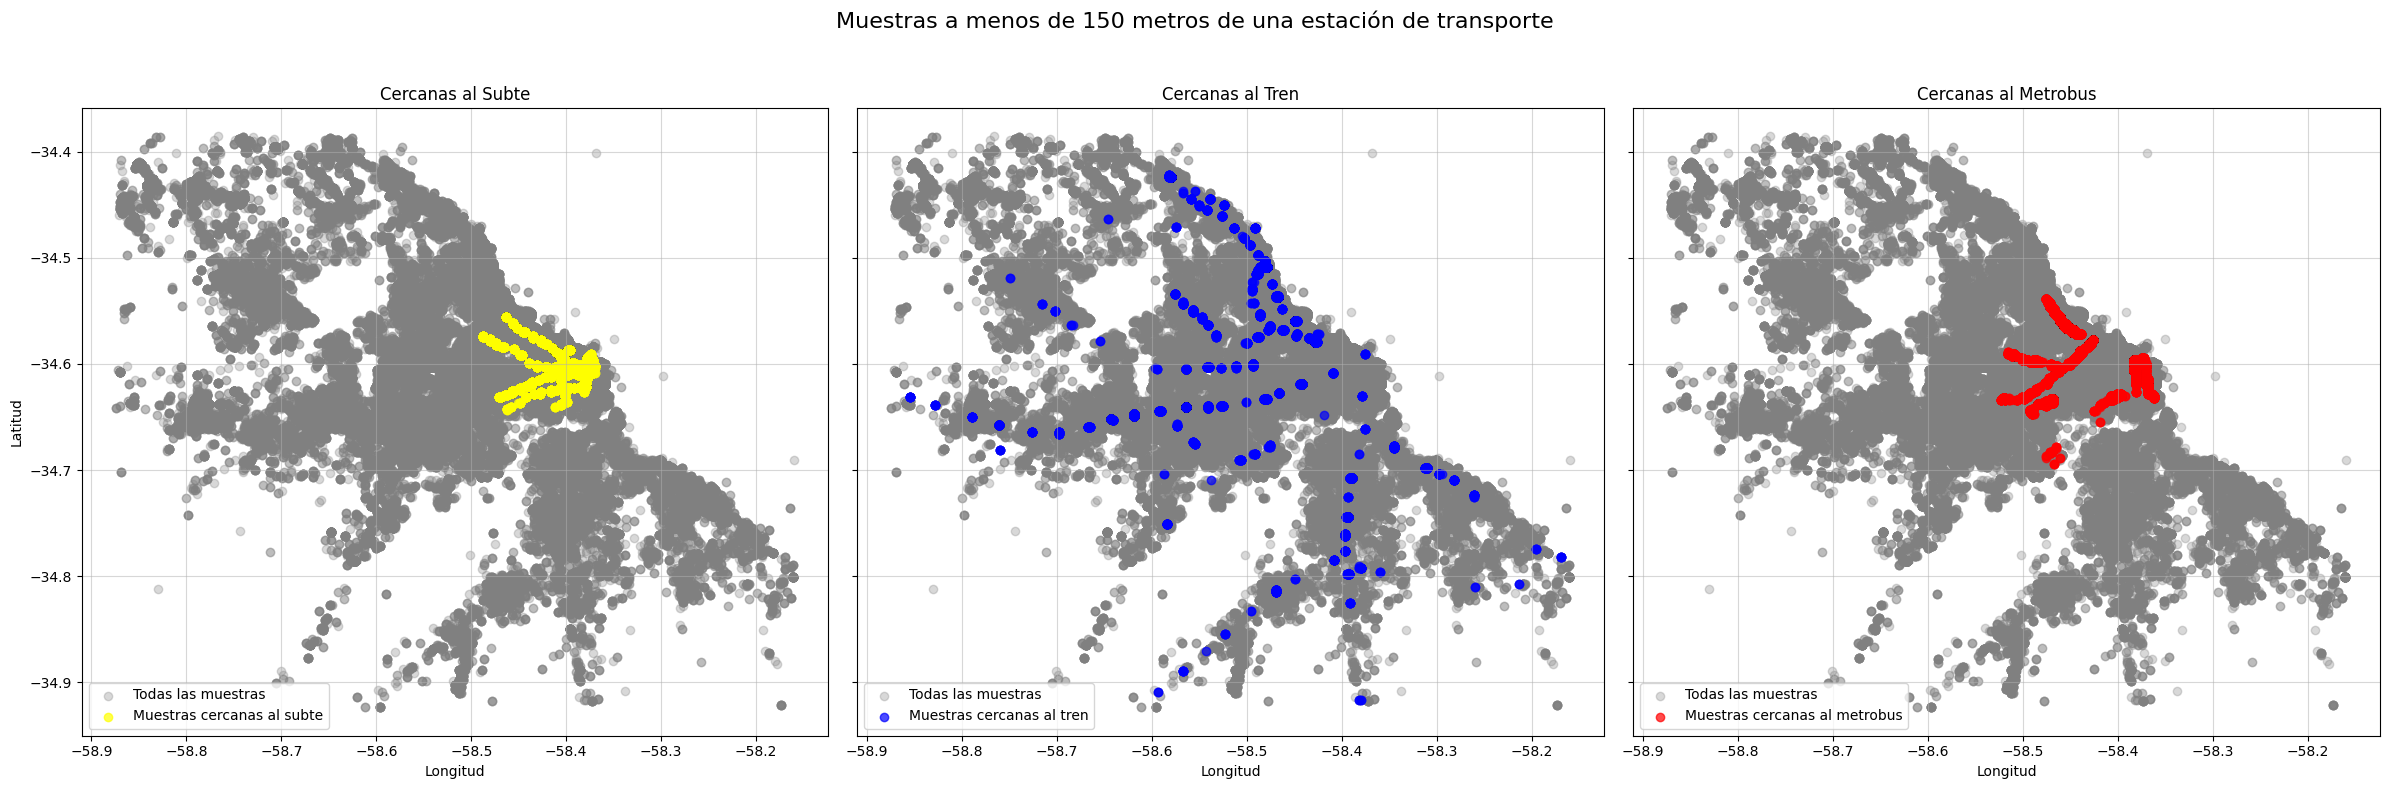

In [9]:
archivo_csv_dist = './data/data_con_dist_a_transporte.csv' 
datita = pd.read_csv(archivo_csv_dist)
distancia = 150 

muestras_cercanas_subte = datita[datita['distancia_subte'] <= distancia]
muestras_cercanas_tren = datita[datita['distancia_tren'] <= distancia]
muestras_cercanas_bus = datita[datita['distancia_bus'] <= distancia]

fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes[0].scatter(datita['LONGITUDE'], datita['LATITUDE'], alpha=0.3, label='Todas las muestras', color='grey')
axes[0].scatter(
    muestras_cercanas_subte['LONGITUDE'],
    muestras_cercanas_subte['LATITUDE'],
    alpha=0.7,
    label='Muestras cercanas al subte',
    color='yellow'
)
axes[0].set_title("Cercanas al Subte")
axes[0].set_xlabel("Longitud")
axes[0].set_ylabel("Latitud")
axes[0].legend()
axes[0].grid(alpha=0.5)
axes[1].scatter(datita['LONGITUDE'], datita['LATITUDE'], alpha=0.3, label='Todas las muestras', color='grey')
axes[1].scatter(
    muestras_cercanas_tren['LONGITUDE'],
    muestras_cercanas_tren['LATITUDE'],
    alpha=0.7,
    label='Muestras cercanas al tren',
    color='blue'
)
axes[1].set_title("Cercanas al Tren")
axes[1].set_xlabel("Longitud")
axes[1].legend()
axes[1].grid(alpha=0.5)
axes[2].scatter(datita['LONGITUDE'], datita['LATITUDE'], alpha=0.3, label='Todas las muestras', color='grey')
axes[2].scatter(
    muestras_cercanas_bus['LONGITUDE'],
    muestras_cercanas_bus['LATITUDE'],
    alpha=0.7,
    label='Muestras cercanas al metrobus',
    color='red'
)
axes[2].set_title("Cercanas al Metrobus")
axes[2].set_xlabel("Longitud")
axes[2].legend()
axes[2].grid(alpha=0.5)
fig.suptitle(f"Muestras a menos de {distancia} metros de una estación de transporte", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

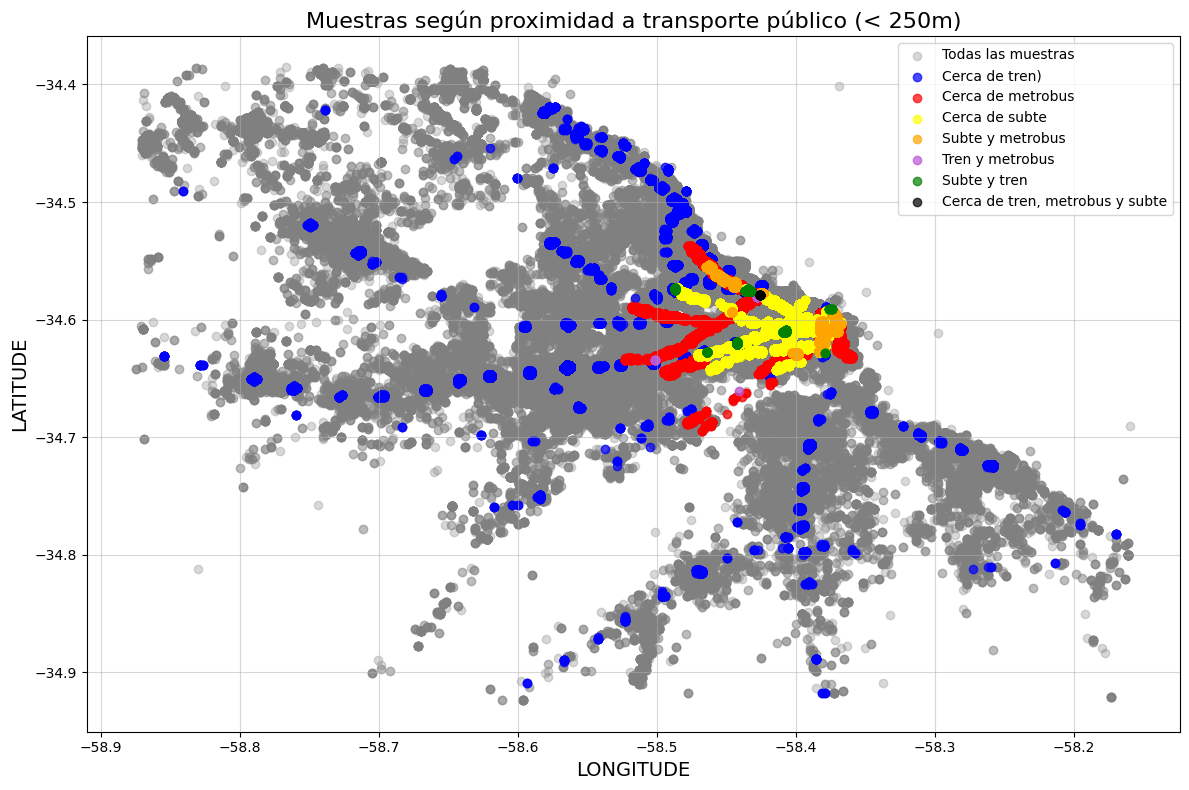

In [10]:
distancia_pa_este_plot = 250 

cond_tren = datita['distancia_tren'] <= distancia_pa_este_plot
cond_bus = datita['distancia_bus'] <= distancia_pa_este_plot
cond_subte = datita['distancia_subte'] <= distancia_pa_este_plot

cond_tren_solo = cond_tren & ~cond_bus & ~cond_subte
cond_bus_solo = cond_bus & ~cond_tren & ~cond_subte
cond_subte_solo = cond_subte & ~cond_tren & ~cond_bus
cond_subte_bus = cond_subte & cond_bus & ~cond_tren
cond_tren_bus = cond_tren & cond_bus & ~cond_subte
cond_tren_subte = cond_tren & cond_subte & ~cond_bus
cond_todas = cond_tren & cond_bus & cond_subte

plt.figure(figsize=(12, 8))
plt.scatter(datita['LONGITUDE'], datita['LATITUDE'], alpha=0.3, label='Todas las muestras', color='grey')
plt.scatter(
    datita[cond_tren_solo]['LONGITUDE'], 
    datita[cond_tren_solo]['LATITUDE'], 
    color='blue', alpha=0.7, label='Cerca de tren)'
)
plt.scatter(
    datita[cond_bus_solo]['LONGITUDE'], 
    datita[cond_bus_solo]['LATITUDE'], 
    color='red', alpha=0.7, label='Cerca de metrobus'
)
plt.scatter(
    datita[cond_subte_solo]['LONGITUDE'], 
    datita[cond_subte_solo]['LATITUDE'], 
    color='yellow', alpha=0.7, label='Cerca de subte'
)
plt.scatter(
    datita[cond_subte_bus]['LONGITUDE'], 
    datita[cond_subte_bus]['LATITUDE'], 
    color='orange', alpha=0.7, label='Subte y metrobus'
)
plt.scatter(
    datita[cond_tren_bus]['LONGITUDE'], 
    datita[cond_tren_bus]['LATITUDE'], 
    color='mediumorchid', alpha=0.7, label='Tren y metrobus'
)
plt.scatter(
    datita[cond_tren_subte]['LONGITUDE'], 
    datita[cond_tren_subte]['LATITUDE'], 
    color='green', alpha=0.7, label='Subte y tren'
)
plt.scatter(
    datita[cond_todas]['LONGITUDE'], 
    datita[cond_todas]['LATITUDE'], 
    color='black', alpha=0.7, label='Cerca de tren, metrobus y subte'
)

plt.title(f"Muestras según proximidad a transporte público (< {distancia_pa_este_plot}m)", fontsize=16)
plt.xlabel("LONGITUDE", fontsize=14)
plt.ylabel("LATITUDE", fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

En el gráfico se observan las propiedades que se encuentran en un rango de 250 metros de cada estación de transporte registrada.

Con los datos ya filtrados y estas nuevas features, se paso a aplicar los modelos. 

Comenzando con la Regresión Polinómica

In [ ]:
archivo_csv = './data/data_con_dist_a_transporte.csv'
data_distancias = pd.read_csv(archivo_csv)

precio_promedio_por_barrio = data_distancias.groupby('ITE_ADD_NEIGHBORHOOD_NAME')['precio_pesos_constantes'].transform('mean')
data_distancias['precio_normalizado'] = data_distancias['precio_pesos_constantes'] - precio_promedio_por_barrio

X = data_distancias[['distancia_tren', 'distancia_subte', 'distancia_bus']]
y = data_distancias['precio_normalizado']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Coeficientes del modelo: {model.coef_}")
print(f"Intercepto: {model.intercept_}")
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R^2: {train_r2:.4f}, Test R^2: {test_r2:.4f}")

data.to_csv('./data/datos_con_precio_normalizado.csv', index=False)

distancias = ['distanciaTren', 'distanciaSubte', 'distanciaBus']
for feature, coef in zip(distancias, model.coef_):
    print(f"La influencia de {feature} en el precio normalizado es {coef:.4f}")


Coeficientes del modelo: [-0.19531065 -1.63693035  1.99918732]
Intercepto: 418.8418380188151
Train MSE: 446612578417.0955, Test MSE: 402969712645.9572
Train R^2: 0.0000, Test R^2: -0.0001
La influencia de distanciaTren en el precio normalizado es -0.1953
La influencia de distanciaSubte en el precio normalizado es -1.6369
La influencia de distanciaBus en el precio normalizado es 1.9992


Primero se aplico el modelo sin filtrar los departamentos con precios exhorbitantes y luego se aplico con el filtro. Esta decisión se tomo luego de observar un R^2 sumamente bajo.

### Ahora sin los datos espurios

In [14]:
data_dist_filtrado = data_distancias[data_distancias['precio_pesos_constantes'] <= 600000]
output_file = './data/datos_filtrados_final_con_disancia.csv'
data_dist_filtrado.to_csv(output_file, index=False)
print(f"Datos filtrados guardados en: {output_file}")



Datos filtrados guardados en: ./data/datos_filtrados_final_con_disancia.csv


In [15]:
data_distancias_filt = pd.read_csv( './data/datos_filtrados_final_con_disancia.csv')

precio_promedio_por_barrio = data_distancias_filt.groupby('ITE_ADD_NEIGHBORHOOD_NAME')['precio_pesos_constantes'].transform('mean')
data_distancias_filt['precio_normalizado'] = data_distancias_filt['precio_pesos_constantes'] - precio_promedio_por_barrio

X = data_distancias_filt[['distancia_tren', 'distancia_subte', 'distancia_bus']]
y = data_distancias_filt['precio_normalizado']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Coeficientes del modelo: {model.coef_}")
print(f"Intercepto: {model.intercept_}")
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R^2: {train_r2:.4f}, Test R^2: {test_r2:.4f}")

data.to_csv('./data/datos_con_precio_normalizado.csv', index=False)

distancias = ['distanciaTren', 'distanciaSubte', 'distanciaBus']
for feature, coef in zip(distancias, model.coef_):
    print(f"La influencia de {feature} en el precio normalizado es {coef:.4f}")


Coeficientes del modelo: [ 0.6327989   0.0557507  -0.06264747]
Intercepto: -825.1075608751855
Train MSE: 1166790005.7296, Test MSE: 1110913904.1899
Train R^2: 0.0003, Test R^2: -0.0000
La influencia de distanciaTren en el precio normalizado es 0.6328
La influencia de distanciaSubte en el precio normalizado es 0.0558
La influencia de distanciaBus en el precio normalizado es -0.0626


Luego de ver que mejoraba el modelo pero no daba resultados buenos, se decidió analizar simplemente CABA, que es la zona más afectada por el transporte público. Y probar estos datos filtrados solo para CABA en nuestro modelo MLP, dado que en provincia no estan todos los transportes.

### Evaluando para CABA

In [17]:
corr_caba_data  = data_distancias_filt[data_distancias_filt['ITE_ADD_STATE_NAME'] == 0.0]
filtro_2 = (
    (data['Ambientes'] == 2) &
    (data['STotalM2'] >= 75) & (data['STotalM2'] <= 85) &
    (data['Cocheras'] == 1) &
    (data['Banos'] == 1)
)

data_corr_CABA_filt = corr_caba_data[filtro_2].copy()

precio_promedio_por_barrio = data_corr_CABA_filt.groupby('ITE_ADD_NEIGHBORHOOD_NAME')['precio_pesos_constantes'].transform('mean')
data_corr_CABA_filt['precio_normalizado'] = data_corr_CABA_filt['precio_pesos_constantes'] - precio_promedio_por_barrio

X = data_corr_CABA_filt[['distancia_tren', 'distancia_subte', 'distancia_bus']]
y = data_corr_CABA_filt['precio_normalizado']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Coeficientes del modelo: {model.coef_}")
print(f"Intercepto: {model.intercept_}")
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R^2: {train_r2:.4f}, Test R^2: {test_r2:.4f}")

data.to_csv('./data/datos_con_precio_normalizado.csv', index=False)

distancias = ['distanciaTren', 'distanciaSubte', 'distanciaBus']
for feature, coef in zip(distancias, model.coef_):
    print(f"La influencia de {feature} en el precio normalizado es {coef:.4f}")


/var/folders/p2/ch6_kmpn1g73c88qsyfcn2_00000gr/T/ipykernel_10698/2855380198.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_corr_CABA_filt = corr_caba_data[filtro_2].copy()


Coeficientes del modelo: [3.04669183 2.09809483 3.40464488]
Intercepto: -9472.235227790696
Train MSE: 1521443191.0636, Test MSE: 3687673506.3603
Train R^2: 0.0093, Test R^2: 0.0011
La influencia de distanciaTren en el precio normalizado es 3.0467
La influencia de distanciaSubte en el precio normalizado es 2.0981
La influencia de distanciaBus en el precio normalizado es 3.4046


Tomando en cuenta que teníamos las zonas separadas por sus precios y ubicaciones, se intentó realizar una seríe de features que tomarán el precio por m^2 promedio por zona y este multiplicarlo por la cantidad de metro cuadrados de cada propiedad. De esta forma se le podía dar al modelo una feature, cercana a la estimación del precio.

In [14]:
data_distancias_filt = pd.read_csv( './data/datos_listos_para_el_modelo.csv')
data_robbie = data_distancias_filt

data_zonas = data_robbie[['LONGITUDE', 'LATITUDE']].copy()
data_zonas['precio_m2'] = data_robbie['precio_pesos_constantes'] / data_robbie['STotalM2']

scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_zonas[['LONGITUDE', 'LATITUDE', 'precio_m2']])

n_clusters = 75
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_zonas['cluster'] = kmeans.fit_predict(df_scaled)

precio_promedio_cluster = data_zonas.groupby('cluster')['precio_m2'].mean()

data_zonas['precio_promedio_m2_cluster'] = data_zonas['cluster'].map(precio_promedio_cluster)

data_zonas['pseudo_precio'] = data_zonas['precio_promedio_m2_cluster'] * data_robbie['STotalM2']

data_robbie['pseudo_precio'] = data_zonas['pseudo_precio']

output_path = './data/datos_con_pseudo_precio.csv'
data_robbie.to_csv(output_path, index=False)

print(f"Archivo actualizado con pseudo precio guardado en: {output_path}")


Archivo actualizado con pseudo precio guardado en: ./data/datos_con_pseudo_precio.csv


In [15]:
#aca se filtran los datos con precios extraorbitarios
archivo_csv = './data/datos_con_pseudo_precio.csv'
data_final = pd.read_csv(archivo_csv, low_memory=False)

data_filtered = data_final[data_final['precio_pesos_constantes'] <= 600000]
output_file = './data/datos_filtrados_con_pseudo_precio.csv'
data_filtered.to_csv(output_file, index=False)

print(f"Datos filtrados guardados en: {output_file}")

Datos filtrados guardados en: ./data/datos_filtrados_con_pseudo_precio.csv


In [22]:
archivo_csv = './data/datos_filtrados_con_pseudo_precio.csv'
data_filtered = pd.read_csv(archivo_csv, low_memory=False)

columns = [col for col in data_filtered.columns if col != 'precio_pesos_constantes'] + ['precio_pesos_constantes']
data_filtered = data_filtered[columns]

output_file = './data/datos_filtrados_con_pseudo_precio_reordenado.csv'
data_filtered.to_csv(output_file, index=False)

print(f"Datos actualizados y guardados en: {output_file}")


Datos actualizados y guardados en: ./data/datos_filtrados_con_pseudo_precio_reordenado.csv


Epoch 1/100


c:\Users\manue\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3434/3434 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 851103296.0000 - mae: 11824.8926 - mse: 851103296.0000 - val_loss: 396040000.0000 - val_mae: 7621.2046 - val_mse: 396040000.0000
Epoch 2/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 393918912.0000 - mae: 7640.4243 - mse: 393918912.0000 - val_loss: 365114016.0000 - val_mae: 7310.6416 - val_mse: 365114016.0000
Epoch 3/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 381942560.0000 - mae: 7305.9414 - mse: 381942560.0000 - val_loss: 349075904.0000 - val_mae: 7035.5479 - val_mse: 349075904.0000
Epoch 4/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 379484160.0000 - mae: 7180.9067 - mse: 379484160.0000 - val_loss: 347524256.0000 - val_mae: 6858.1802 - val_mse: 347524256.0000
Epoch 5/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 362500256.0000 - mae: 7061.1333 - mse: 362500256.0000 - val_loss: 334714816.0000 - val_mae: 6913.2280 - val_mse: 334714816.0000
Epoch 6/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/

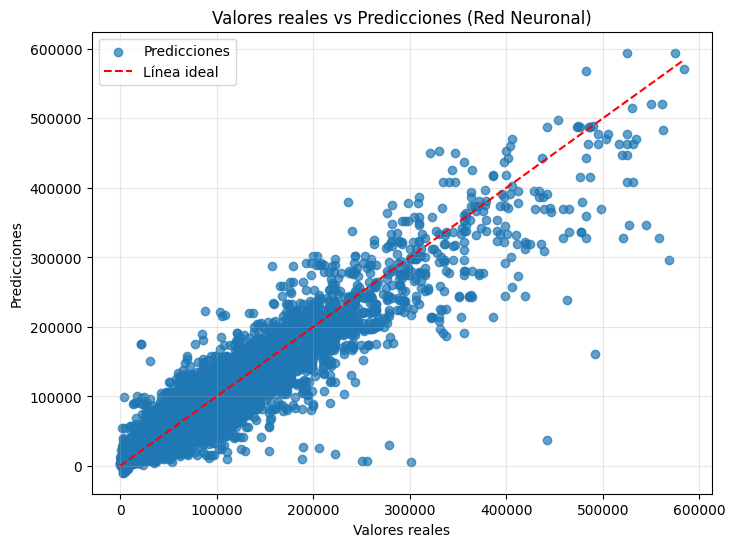

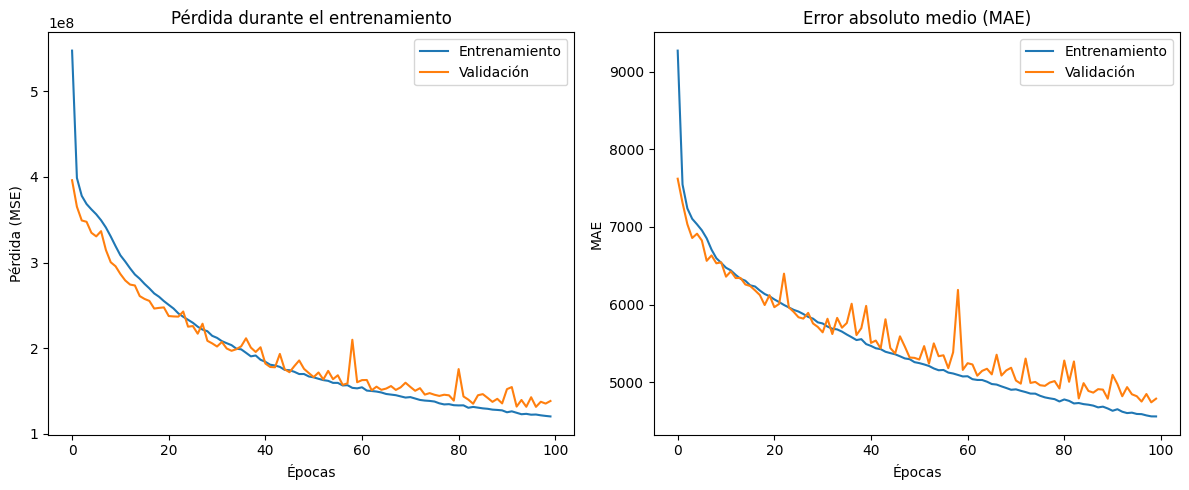

In [23]:
archivo_csv = './data/datos_filtrados_con_pseudo_precio_reordenado.csv'
data_filtrada = pd.read_csv(archivo_csv, low_memory=False)

X = data_filtrada.iloc[:, :-1]  
y = data_filtrada.iloc[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

history = model.fit(
    X_train_scaled, Y_train,
    validation_data=(X_test_scaled, Y_test),
    epochs=100,  
    batch_size=64,
    verbose=1
)

train_loss, train_mae, train_mse = model.evaluate(X_train_scaled, Y_train, verbose=0)
test_loss, test_mae, test_mse = model.evaluate(X_test_scaled, Y_test, verbose=0)

Y_test_pred_nn = model.predict(X_test_scaled).flatten()

train_r2_nn = r2_score(Y_train, model.predict(X_train_scaled).flatten())
test_r2_nn = r2_score(Y_test, Y_test_pred_nn)
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R^2: {train_r2_nn:.4f}, Test R^2: {test_r2_nn:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_test_pred_nn, alpha=0.7, label='Predicciones')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', label='Línea ideal')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones (Red Neuronal)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title("Error absoluto medio (MAE)")
plt.xlabel("Épocas")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.show()


Se pudo oberservar que agreagar esta feature al modelo, no mejoro su rendimiento.

## Predicciones con dataset Transporte

Una vez descartado el feature de precio promedio por zona * m^2 de cada propiedad, se le aplico al dataset que contaba con las distancias de cada propiedad al transporte público el modelo de MLP, para ver si estas neuvas features podian aportar una mejora significativa. 


In [19]:
#aca se filtran los datos con precios extraorbitarios
archivo_csv = './data/data_con_dist_a_transporte.csv'
data_final = pd.read_csv(archivo_csv, low_memory=False)

data_filtered = data_final[data_final['precio_pesos_constantes'] <= 600000]
output_file = './data/datos_filtrados_transporte.csv'
data_filtered.to_csv(output_file, index=False)

print(f"Datos filtrados guardados en: {output_file}")

Datos filtrados guardados en: ./data/datos_filtrados_transporte.csv


In [20]:
# Cargar los datos filtrados
archivo_csv = './data/datos_filtrados_transporte.csv'
data_filtered = pd.read_csv(archivo_csv, low_memory=False)

# Mover la columna 'precio_pesos_constantes' a la última posición
columns = [col for col in data_filtered.columns if col != 'precio_pesos_constantes'] + ['precio_pesos_constantes']
data_filtered = data_filtered[columns]

# Guardar el dataset actualizado
output_file = './data/datos_filtrados_transporte_reordenado.csv'
data_filtered.to_csv(output_file, index=False)

print(f"Datos actualizados y guardados en: {output_file}")


Datos actualizados y guardados en: ./data/datos_filtrados_transporte_reordenado.csv


Epoch 1/100


c:\Users\manue\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3434/3434 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 844917376.0000 - mae: 11917.6455 - mse: 844917376.0000 - val_loss: 413779808.0000 - val_mae: 7747.2158 - val_mse: 413779808.0000
Epoch 2/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 422365728.0000 - mae: 7760.4370 - mse: 422365728.0000 - val_loss: 368728384.0000 - val_mae: 7197.4121 - val_mse: 368728384.0000
Epoch 3/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 390099456.0000 - mae: 7257.7695 - mse: 390099456.0000 - val_loss: 354263136.0000 - val_mae: 7056.0220 - val_mse: 354263136.0000
Epoch 4/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 375262560.0000 - mae: 7092.0068 - mse: 375262560.0000 - val_loss: 349915776.0000 - val_mae: 6993.3286 - val_mse: 349915776.0000
Epoch 5/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 351041920.0000 - mae: 6908.3818 - mse: 351041920.0000 - val_loss: 345793280.0000 - val_mae: 7146.1865 - val_mse: 345793280.0000
Epoch 6/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/ste

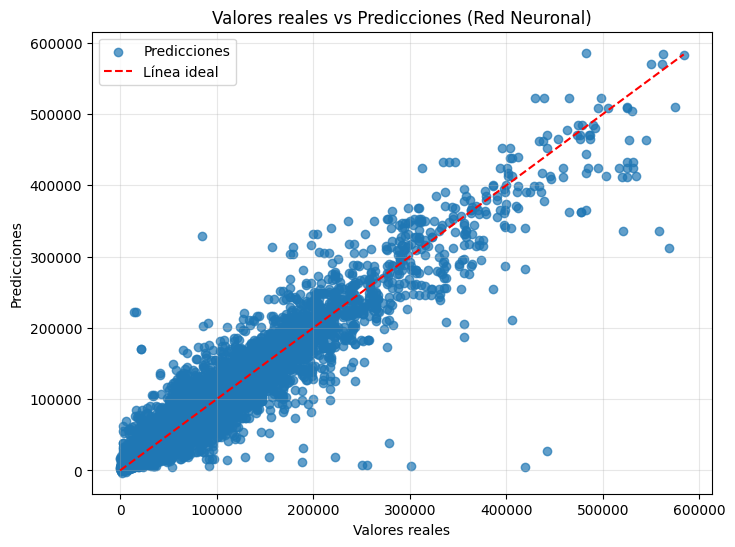

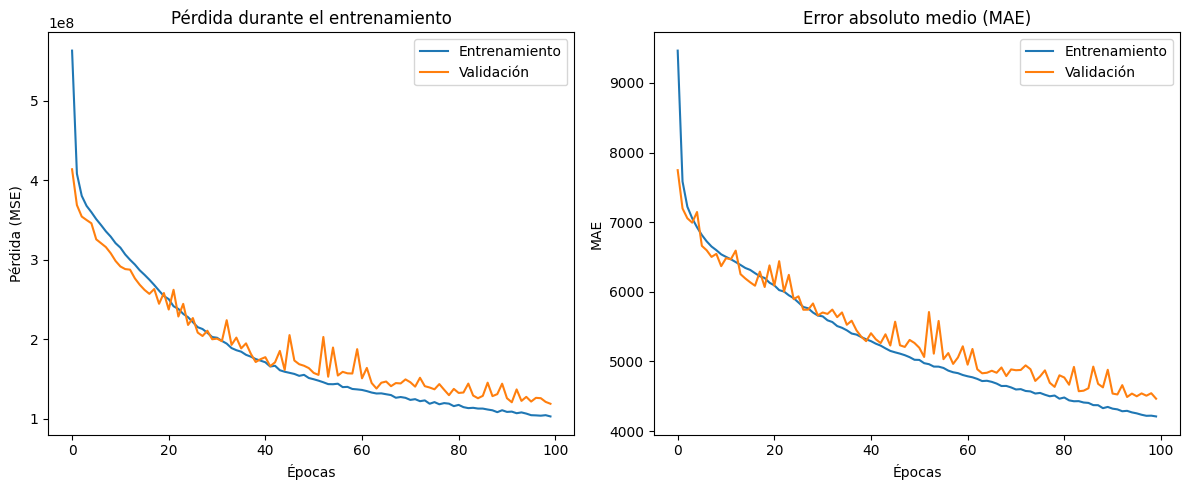

In [40]:
archivo_csv = './data/datos_filtrados_transporte_reordenado.csv'
data_filtrada = pd.read_csv(archivo_csv, low_memory=False)

X = data_filtrada.iloc[:, :-1]  
y = data_filtrada.iloc[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

history = model.fit(
    X_train_scaled, Y_train,
    validation_data=(X_test_scaled, Y_test),
    epochs=100,  
    batch_size=64,
    verbose=1
)

train_loss, train_mae, train_mse = model.evaluate(X_train_scaled, Y_train, verbose=0)
test_loss, test_mae, test_mse = model.evaluate(X_test_scaled, Y_test, verbose=0)

Y_test_pred_nn = model.predict(X_test_scaled).flatten()

train_r2_nn = r2_score(Y_train, model.predict(X_train_scaled).flatten())
test_r2_nn = r2_score(Y_test, Y_test_pred_nn)
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R^2: {train_r2_nn:.4f}, Test R^2: {test_r2_nn:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_test_pred_nn, alpha=0.7, label='Predicciones')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', label='Línea ideal')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones (Red Neuronal)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title("Error absoluto medio (MAE)")
plt.xlabel("Épocas")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.show()


Luego de entrenar el modelo, se vio una mejora muy pequeña en el R^2, lo cual indica que la adición de estos features no afecta significatiavamente el rendimiento de la MLP.

C:\Users\manue\AppData\Local\Temp\ipykernel_25360\3395071246.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_corr_CABA_filt = data_distancias_filt[filtro_3].copy()


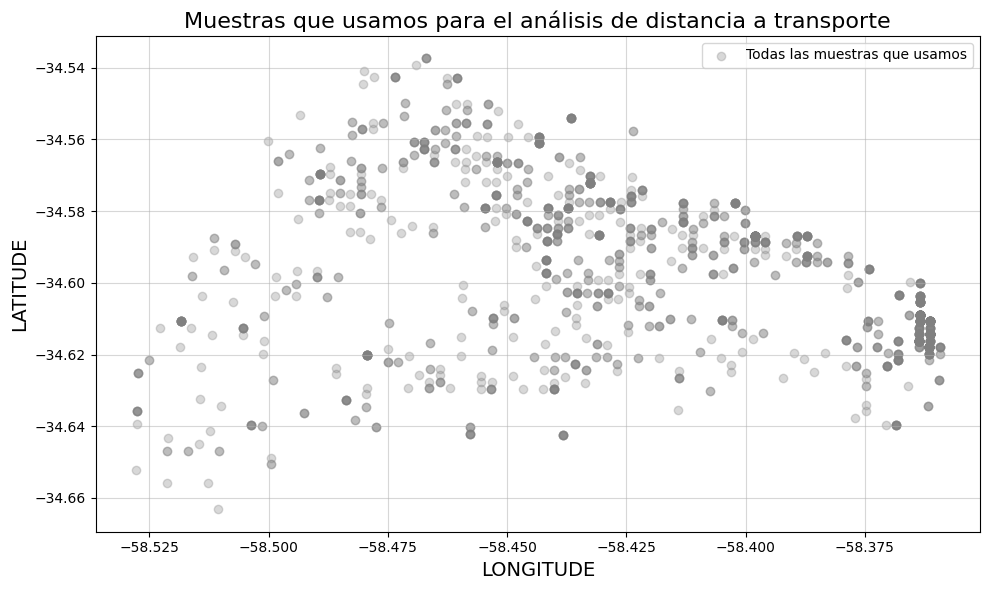

Coeficiente de correlación: 0.046446776359712526


In [19]:
data_distancias_filt = pd.read_csv( './data/datos_filtrados_final_con_disancia.csv')

filtro_3 = (
    (data_distancias_filt['Ambientes'] == 2) &
    (data_distancias_filt['STotalM2'] >= 65) & (data['STotalM2'] <= 85) &
    (data_distancias_filt['Cocheras'] == 0) &
    (data_distancias_filt['Banos'] == 1) &
    (data_distancias_filt['ITE_ADD_STATE_NAME'] == 0.0) &
    (data_distancias_filt['ITE_ADD_NEIGHBORHOOD_NAME'] > 50)

)
data_corr_CABA_filt = data_distancias_filt[filtro_3].copy()
data_corr_CABA_filt['precio_m2'] = data_corr_CABA_filt['precio_pesos_constantes'] / data_corr_CABA_filt['STotalM2']

scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_corr_CABA_filt[['LONGITUDE', 'LATITUDE', 'precio_m2']])
n_clusters = 40
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_corr_CABA_filt['cluster'] = kmeans.fit_predict(df_scaled)
precio_promedio_cluster = data_corr_CABA_filt.groupby('cluster')['precio_m2'].mean()
data_corr_CABA_filt['precio_promedio_m2_cluster'] = data_corr_CABA_filt['cluster'].map(precio_promedio_cluster)
data_corr_CABA_filt['precio_promedio_m2_normalizado'] = data_corr_CABA_filt['precio_m2'] - data_corr_CABA_filt['precio_promedio_m2_cluster']

plt.figure(figsize=(10, 6))
plt.scatter(data_corr_CABA_filt['LONGITUDE'], data_corr_CABA_filt['LATITUDE'], alpha=0.3, label='Todas las muestras que usamos', color='grey')
plt.title(f"Muestras que usamos para el análisis de distancia a transporte", fontsize=16)
plt.xlabel("LONGITUDE", fontsize=14)
plt.ylabel("LATITUDE", fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

correlation = data_corr_CABA_filt['distancia_subte'].corr(data_corr_CABA_filt['precio_promedio_m2_normalizado'], method='pearson')  # Cambia a 'spearman' si es necesario
print(f"Coeficiente de correlación: {correlation}")

Luego de analizar la correlación y el rendimiento de la MLP, pudimos concluir que en este caso, la cercanía de las propiedades al transporte público no es un feature que afecte directamente el precio de su alquiler. Por lo tanto, no impacto de manera significativa en el rendimeinto de los modelos.

---
# TEST

Se evaluo el rendimiento del modelo con un test_set dato por la cátedra 24hrs antes de la entrega.

In [2]:
data_test = pd.read_csv('./data/alquiler_AMBA_test.csv')
data_test_preprocesing = mapeo(data_test)
data_train = pd.read_csv('./data/datos_filtrados.csv')


X_train = data_train[['LONGITUDE', 'LATITUDE']].values
y_train = data_train['ITE_ADD_NEIGHBORHOOD_NAME'].values
X_test = data_test_preprocesing[['LONGITUDE', 'LATITUDE']].values

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

predicciones = knn.predict(X_test)

data_test_preprocesing['ITE_ADD_NEIGHBORHOOD_NAME'] = predicciones

output_path = './data/alquiler_AMBA_test_actualizado.csv'
data_test_preprocesing.to_csv(output_path, index=False)

print(f"Dataset actualizado guardado en: {output_path}")


Dataset actualizado guardado en: ./data/alquiler_AMBA_test_actualizado.csv


Se preproceso el dataset y se realizo el encoding de la columna Neighbouhood.

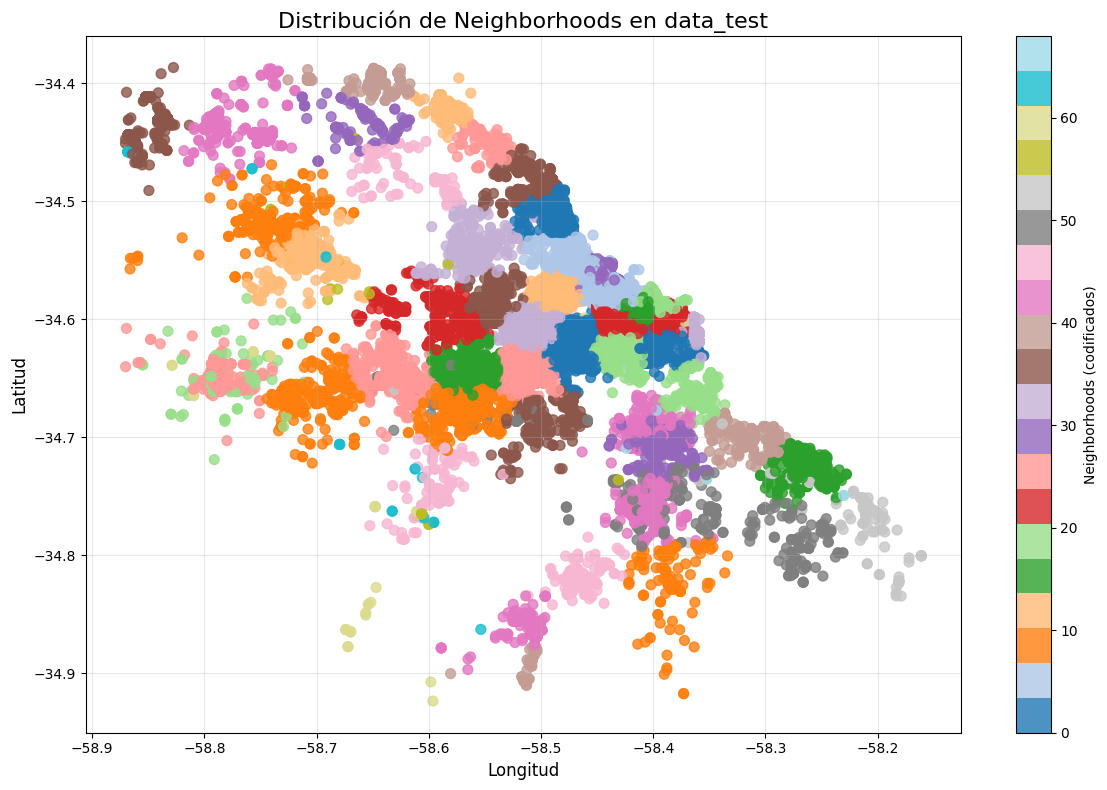

In [3]:

data_test_actualizado = pd.read_csv('./data/alquiler_AMBA_test_actualizado.csv')

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    data_test_actualizado['LONGITUDE'], 
    data_test_actualizado['LATITUDE'], 
    c=pd.factorize(data_test_actualizado['ITE_ADD_NEIGHBORHOOD_NAME'])[0],  
    cmap='tab20',  
    alpha=0.8,  
    s=50 
)


plt.title("Distribución de Neighborhoods en data_test", fontsize=16)
plt.xlabel("Longitud", fontsize=12)
plt.ylabel("Latitud", fontsize=12)
plt.colorbar(scatter, label='Neighborhoods (codificados)')
plt.grid(alpha=0.3)
plt.tight_layout()


plt.show()


## Predicciones con Regresion

In [36]:
test_csv_path = './data/alquiler_AMBA_test_actualizado.csv'
data_test = pd.read_csv(test_csv_path, low_memory=False)

X_test_new = data_test.iloc[:, 1:]  

degree = 2  
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_test_poly_new = poly_features.fit_transform(X_test_new)

regression_model = LinearRegression()
regression_model.fit(X_train_poly, Y_train_reg)
predicted_prices = regression_model.predict(X_test_poly_new)

results = pd.DataFrame({
    'id': data_test.iloc[:, 0], 
    'predicted_price': predicted_prices
})

output_path = './data/GomezPazos_Grunewald_Regression_Predictions.csv'
results.to_csv(output_path, index=False)

print(f"Predicciones guardadas en: {output_path}")

c:\Users\manue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 8517.3684
RMSE: 19132.3845
R^2: 0.8144
Predicciones guardadas en: ./data/GomezPazos_Grunewald_Regression_Predictions.csv


Ahora predecimos con la red neuronal

In [38]:
test_csv_path = './data/alquiler_AMBA_test_actualizado.csv'
data_test_mlp = pd.read_csv(test_csv_path, low_memory=False)

X_test_new_mlp = data_test.iloc[:, 1:]  

scaler = StandardScaler()
X_test_scaled_mlp = scaler.fit_transform(X_test_new)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

history = model.fit(
    X_train_scaled, Y_train_mlp,
    validation_data=(X_test_scaled, Y_test_mlp),
    epochs=100,  
    batch_size=64,
    verbose=1
)

train_loss, train_mae, train_mse = model.evaluate(X_train_scaled, Y_train_mlp, verbose=0)
test_loss, test_mae, test_mse = model.evaluate(X_test_scaled, Y_test_mlp, verbose=0)

predicted_prices = model.predict(X_test_scaled_mlp).flatten()

mae = mean_absolute_error(Y_test_mlp, model.predict(X_test_scaled).flatten())
rmse = mean_squared_error(Y_test_mlp, model.predict(X_test_scaled).flatten(), squared=False)
r2 = r2_score(Y_test_mlp, model.predict(X_test_scaled).flatten())

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

results = pd.DataFrame({
    'id': data_test.iloc[:, 0],  
    'predicted_price': predicted_prices
})

output_path = './data/GomezPazos_Grunewald_NN_Predictions.csv'
results.to_csv(output_path, index=False)

print(f"Predicciones guardadas en: {output_path}")


Epoch 1/100


c:\Users\manue\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3434/3434 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 831887040.0000 - mae: 11884.1006 - mse: 831887040.0000 - val_loss: 401231936.0000 - val_mae: 7832.3008 - val_mse: 401231936.0000
Epoch 2/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 404284960.0000 - mae: 7781.3867 - mse: 404284960.0000 - val_loss: 364116928.0000 - val_mae: 7489.4678 - val_mse: 364116928.0000
Epoch 3/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 391014944.0000 - mae: 7421.4512 - mse: 391014944.0000 - val_loss: 357553856.0000 - val_mae: 7460.0015 - val_mse: 357553856.0000
Epoch 4/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 344561952.0000 - mae: 7088.7686 - mse: 344561952.0000 - val_loss: 341626624.0000 - val_mae: 7054.4800 - val_mse: 341626624.0000
Epoch 5/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 376058592.0000 - mae: 7173.1943 - mse: 376058592.0000 - val_loss: 336142496.0000 - val_mae: 6941.7910 - val_mse: 336142496.0000
Epoch 6/100
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step 

c:\Users\manue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1717/1717 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step
MAE: 4970.0180
RMSE: 12295.5513
R^2: 0.9217
Predicciones guardadas en: ./data/GomezPazos_Grunewald_NN_Predictions.csv


Scatter Plot para ver si predicen parecido

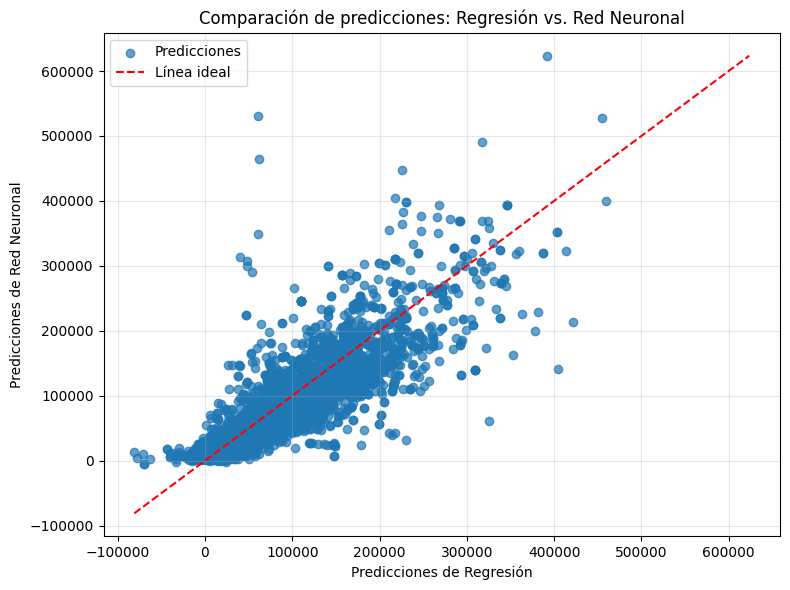

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

regression_predictions_path = './data/GomezPazos_Grunewald_Regression_Predictions.csv'
nn_predictions_path = './data/GomezPazos_Grunewald_NN_Predictions.csv'

regression_predictions = pd.read_csv(regression_predictions_path)
nn_predictions = pd.read_csv(nn_predictions_path)

merged_predictions = pd.merge(
    regression_predictions, 
    nn_predictions, 
    on='id', 
    suffixes=('_regression', '_nn')
)

plt.figure(figsize=(8, 6))
plt.scatter(
    merged_predictions['predicted_price_regression'], 
    merged_predictions['predicted_price_nn'], 
    alpha=0.7, 
    label='Predicciones'
)

min_val = min(merged_predictions['predicted_price_regression'].min(), merged_predictions['predicted_price_nn'].min())
max_val = max(merged_predictions['predicted_price_regression'].max(), merged_predictions['predicted_price_nn'].max())
plt.plot([min_val, max_val], [min_val, max_val], '--r', label='Línea ideal')

plt.title("Comparación de predicciones: Regresión vs. Red Neuronal")
plt.xlabel("Predicciones de Regresión")
plt.ylabel("Predicciones de Red Neuronal")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Con este gráfico pudimos observar que ambos modelos estan prediciendo sobre el test set de manera coherente.